<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'>MCMC </font></h3>
    
    MCMCの計算を行うコードを実行しています。
    Persuasive Python by Adam Fleischhacker 
    https://www.persuasivepython.com/
    
    のコードをライセンスに従って使用しています。
  

/tmp/ipykernel_42/3085080301.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


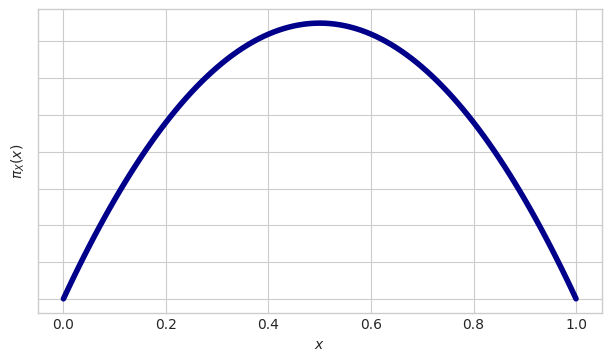

In [1]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

def pi_X(x):
    if x >= 0 and x <= 1:
        return 6*x*(1-x)
    
    else:
        return 0

x = [i/100 for i in range(101)]
y = [pi_X(i) for i in x]

fig, ax = plt.subplots(figsize=(6, 3.5), layout='constrained')
ax.plot(x, y, color='darkblue', linewidth=4)
ax.set(xlabel=r'$x$', ylabel=r'$\pi_X(x)$')
ax.set_yticklabels([])

plt.show();

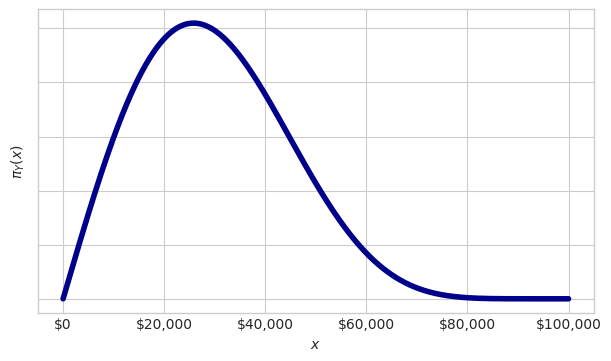

In [2]:
from matplotlib.ticker import FuncFormatter

def pi_Y(y):
    kumaRealization = y / 100000
    jacobian = 1 / 10**5
    if kumaRealization >= 0 and kumaRealization <= 1:
        return 2*8*kumaRealization*(1-kumaRealization**2)**7*jacobian
    else:
        return 0
    
def dollar_format(x, pos):
    """Format y-axis tick Labels in dollar format"""
    return '${:,.0f}'.format(x)

x = [i for i in range(100001)]
y = [pi_Y(i) for i in x]

fig, ax = plt.subplots(figsize=(6, 3.5), layout='constrained')
ax.plot(x, y, color='darkblue', linewidth=4)
ax.set(xlabel=r'$x$', ylabel=r'$\pi_Y(x)$')
ax.xaxis.set_major_formatter(FuncFormatter(dollar_format))
ax.set_yticklabels([])

plt.show()

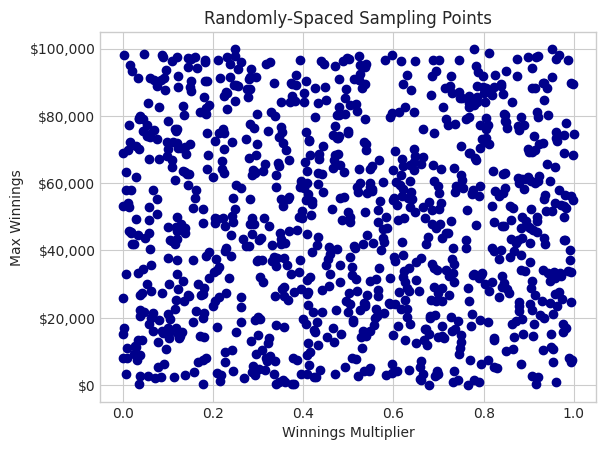

In [3]:
import pandas as pd
import numpy as np

N = 1000 ## 1000でのサンプル

gridDF = pd.DataFrame({'winningsMultiplier': np.random.rand(N),
                       'maxWinnings': 10**5*np.random.rand(N)})

fig, ax = plt.subplots()
ax.scatter(gridDF['winningsMultiplier'], gridDF['maxWinnings'], color='darkblue')
ax.yaxis.set_major_formatter(FuncFormatter(dollar_format))

# 軸ラベルとタイトルを設定
ax.set_xlabel('Winnings Multiplier')
ax.set_ylabel('Max Winnings')
ax.set_title('Randomly-Spaced Sampling Points')

plt.show()

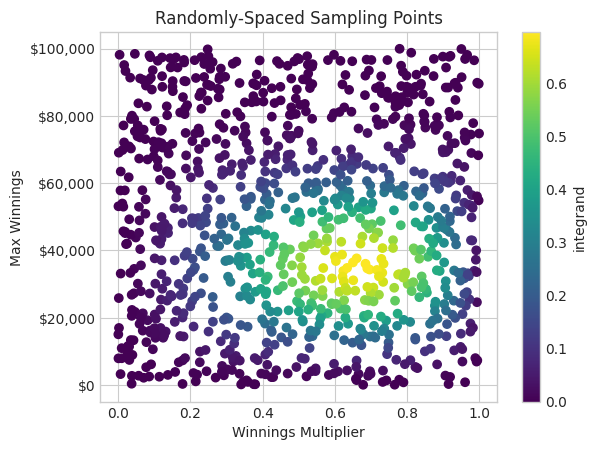

In [4]:
# 積分関数を定義する
def integrandFun(x, y):
    return 3*x**2*y**2 / (3125*10**5)*(1-x)*(1-y**2/10**10)**7

# 上の関数を使ってデータフレームに列を追加する
gridDF['integrand'] = gridDF.apply(lambda row: integrandFun(row['winningsMultiplier'], row['maxWinnings']), axis=1)

fig, ax = plt.subplots()
winPlot = ax.scatter(gridDF['winningsMultiplier'], gridDF['maxWinnings'], c=gridDF['integrand'], cmap='viridis')
ax.yaxis.set_major_formatter(FuncFormatter(dollar_format))

# ラベルとタイトルを設定する
ax.set_xlabel('Winnings Multiplier')
ax.set_ylabel('Max Winnings')
ax.set_title('Randomly-Spaced Sampling Points')

fig.colorbar(winPlot, label='integrand')

plt.show()

In [5]:
expectedWinnings = 10**5 * np.mean(gridDF['integrand'])
print("Expected Winnings: " + dollar_format(expectedWinnings, None))

Expected Winnings: $15,688


In [6]:
gridDF.sample(n=10)

,winningsMultiplier,maxWinnings,integrand
794,0.418414,53677.933952,0.260906
536,0.604940,60325.068412,0.212803
207,0.592187,31693.144206,0.657314
718,0.518115,58744.574527,0.221443
575,0.767769,82693.700446,0.002839
145,0.732672,922.007387,0.001170
383,0.933559,19955.695086,0.166566
986,0.120982,75973.437207,0.001722
289,0.953796,21092.229443,0.130545
631,0.367534,55970.797621,0.185061


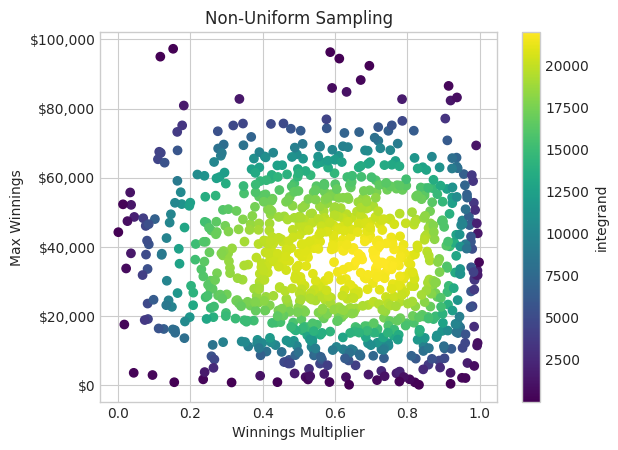

In [7]:
from scipy.stats import truncnorm

## 分布のバウンドは、実際のバウンドではなくsdの範囲内にある

xSamplingDist = truncnorm((0 - 0.65) / 0.3, (1-0.65)/0.3, loc=0.65, scale=0.3) # winnings winningsMultiplier
ySamplingDist = truncnorm((0 - 35000) / 20000, (100000 - 35000) / 20000, loc=35000.0, scale=20000.0) # maxWinnings

# 分布からのサンプル
np.random.seed(123)
n = 1000 
winningsMultiplier = xSamplingDist.rvs(n)
maxWinnings = ySamplingDist.rvs(n)

integrand = integrandFun(winningsMultiplier, maxWinnings) / (xSamplingDist.pdf(winningsMultiplier) * ySamplingDist.pdf(maxWinnings))

# 散布図の作成
fig, ax = plt.subplots()
winPlot = ax.scatter(winningsMultiplier, maxWinnings, c=integrand, cmap='viridis')

# 軸ラベルとタイトルを設定
ax.yaxis.set_major_formatter(FuncFormatter(dollar_format))
ax.set_xlabel('Winnings Multiplier')
ax.set_ylabel('Max Winnings')
ax.set_title('Non-Uniform Sampling')

fig.colorbar(winPlot, label='integrand')
plt.show()

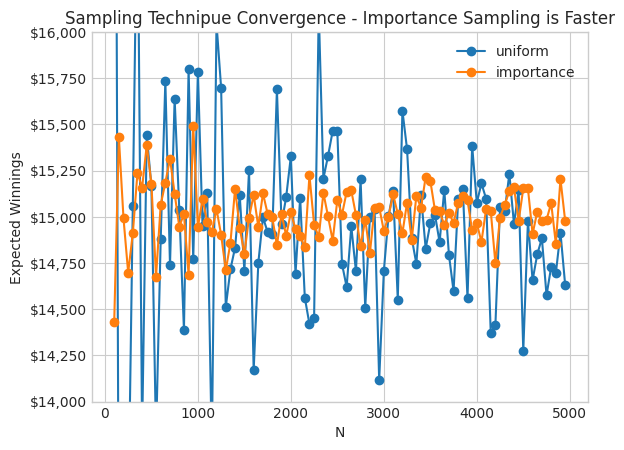

In [8]:
# 収束の比較
N_values = np.arange(100, 5000, step=50)

sim_results = []

def integrandFun2(x, y):
    return integrandFun(x, y) / (xSamplingDist.pdf(x) * ySamplingDist.pdf(y))

for N in N_values:
    # 一様サンプリング
    winningsMultiplier = np.random.rand(N)
    maxWinnings = 10**5 * np.random.rand(N)
    integrand_unif = integrandFun(winningsMultiplier, maxWinnings)
    expWinnings_unif = 10**5 * np.mean(integrand_unif)
    sim_results.append((N, 'uniform', expWinnings_unif))
    
    # 重要度サンプリング
    x_samples = truncnorm.rvs((0 - 0.65) / 0.3, (1 - 0.65) / 0.3, size=N, loc=0.65, scale=0.3)
    y_samples = truncnorm.rvs((0 - 35000) / 20000, (100000 - 35000) / 20000, size=N, loc=35000, scale=20000)
    integrand_imp = integrandFun2(x_samples, y_samples)
    expWinnings_imp = np.mean(integrand_imp)
    sim_results.append((N, 'importance', expWinnings_imp))
    
# 結果のプロット
fig, ax = plt.subplots()
for label in ['uniform', 'importance']:
    x, y = zip(*[(N, expWinnings) for N, method, expWinnings in sim_results if method == label])
    ax.plot(x, y, label=label, marker='o')
    
ax.set_xlabel('N')
ax.set_ylabel('Expected Winnings')
ax.set_title('Sampling Technipue Convergence - Importance Sampling is Faster')
ax.set_ylim(14000, 16000)

ax.yaxis.set_major_formatter(dollar_format)
ax.legend()
plt.show()

In [9]:
# initial point - pick extreme point for illustration
qDF = pd.DataFrame({
    'winningsMultiplier': [0.99],
    'maxWinnings': [99000.0]
})

In [10]:
from numpy.random import default_rng
rng = default_rng(54321)

rng = default_rng(123)
jumpDist = rng.multivariate_normal(np.zeros(2), np.diag([0.1**2, 200**2]))

q_current = qDF.iloc[0].to_numpy()
q_proposed = q_current + jumpDist

In [11]:
# パラメータが列として入れられたときのqの密度
def pi_Q(q):
    return pi_X(q[0]) * pi_Y(q[1])

acceptanceProb = min(1, pi_Q(q_proposed) / pi_Q(q_current))
print(acceptanceProb)

1


In [12]:
def addPoint(drawsDF, q_proposed, acceptanceProb):
    if np.random.binomial(1, acceptanceProb):
        drawsDF.loc[drawsDF.index[-1]+1] = q_proposed # 提案された点へ動く
    
    else:
        q = drawsDF.iloc[-1].to_numpy()
        drawsDF.loc[drawsDF.index[-1]+1] = q_current # 同じ点に留まる
        
addPoint(qDF, q_proposed, acceptanceProb)
print(qDF)

   winningsMultiplier  maxWinnings
0            0.990000  99000.00000
1            0.953221  98802.17573


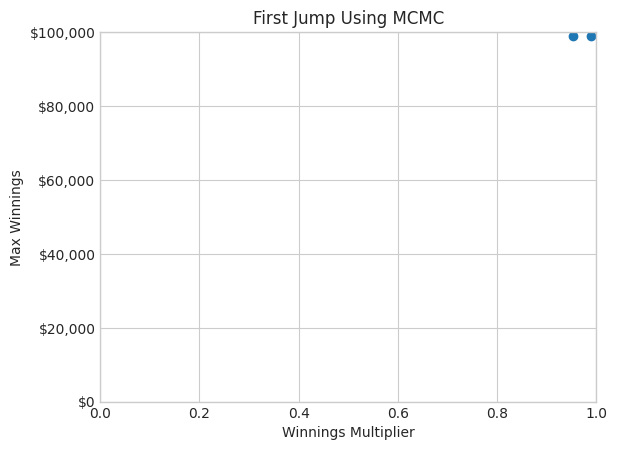

In [13]:
# プロットを作る
fig, ax = plt.subplots()
ax.scatter(qDF.winningsMultiplier, qDF.maxWinnings)

# 軸ラベルとタイトルを設定
ax.yaxis.set_major_formatter(FuncFormatter(dollar_format))
ax.set_xlabel('Winnings Multiplier')
ax.set_ylabel('Max Winnings')
ax.set_title('First Jump Using MCMC')
ax.set_xlim(0, 1)
ax.set_ylim(0, 100000)
plt.show()

In [16]:
for i in range(200):
    jumpDist = rng.multivariate_normal(np.zeros(2), np.diag([0.1**2, 200**2]))
    q_current = qDF.iloc[i].to_numpy()
    q_proposed = q_current + jumpDist
    acceptanceProb = min(1, pi_Q(q_proposed) / pi_Q(q_current))
    addPoint(qDF, q_proposed, acceptanceProb)

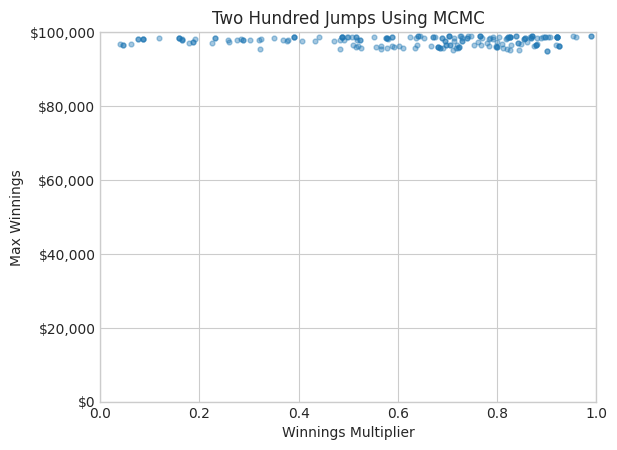

In [19]:
# 散布図をつくる
fig, ax = plt.subplots()
ax.scatter(qDF.winningsMultiplier, qDF.maxWinnings, s=12, alpha=0.4)

# 軸ラベルとタイトルの設定
ax.yaxis.set_major_formatter(FuncFormatter(dollar_format))
ax.set_xlabel('Winnings Multiplier')
ax.set_ylabel('Max Winnings')
ax.set_title('Two Hundred Jumps Using MCMC')
ax.set_xlim(0, 1)
ax.set_ylim(0, 100000)
plt.show()